In [8]:
# !pip install gtts pydub audioop-lts
from pydub import AudioSegment
import time
import os
import pandas as pd
import glob
from collections import defaultdict
from PIL import Image, ImageDraw, ImageFont
from moviepy import ImageClip, TextClip, CompositeVideoClip, AudioFileClip
hanzi_font_path = '/System/Library/Fonts/STHeiti Medium.ttc'
pd.options.display.max_columns = 100

In [13]:
# related audio recording id
recording_id = '001'
recording_name = '0814_word_p2_k2_sent'

# 1. Load & select data

In [3]:
cols_keep = [
    'chinese', 'pinyin', 'english',
    'type', 'priority', 'known', 'known_pinyin_prompt', 'known_english_prompt',
    'phonetic', 'category1', 'quality',
    'word1', 'word1_english', 'word2', 'word2_english', 'word3', 'word3_english', 'word4', 'word4_english',
    'sentence', 'sentence_pinyin', 'sentence_english', 'date']
sheet_url = 'https://docs.google.com/spreadsheets/d/1pw9EAIvtiWenPDBFBIf7pwTh0FvIbIR0c3mY5gJwlDk/edit#gid=0'
sheet_url = sheet_url.replace('/edit#gid=', '/export?format=csv&gid=')
df = pd.read_csv(sheet_url)[cols_keep]
df = df.dropna(subset=['chinese', 'english'])
print(df.shape)
df.head()

(4565, 23)


,chinese,pinyin,english,type,priority,known,known_pinyin_prompt,known_english_prompt,phonetic,category1,quality,word1,word1_english,word2,word2_english,word3,word3_english,word4,word4_english,sentence,sentence_pinyin,sentence_english,date
0,房贷,fáng dài,mortgage,combo,1.0,1.0,1.0,2.0,NaN,life,1.0,房,house,贷,loan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,保险,bǎo xiǎn,insurance,combo,1.0,1.0,1.0,2.0,NaN,life,1.0,保,protect,危险,danger,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,周一,zhōu yī,monday,combo,1.0,1.0,1.0,1.0,NaN,general,1.0,周,week,一,one,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,一月,yī yuè,january,combo,1.0,1.0,1.0,1.0,NaN,general,1.0,一,one,月,month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,黄金,huáng jīn,gold,combo,1.0,1.0,1.0,1.0,NaN,industry,1.0,黄,yellow,金,metal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Which data to use this time?
types_not_allowed = ['phrase', 'sentence', 'part sent', 'phrase_save']
df_this = (
    df[
        (df['priority'] <= 2) &
        (df['known_english_prompt'] >= 2) &
        (~df['type'].isin(types_not_allowed))
    ]
    .sort_values(['category1', 'pinyin'], ascending=[True, True])
    .dropna(subset=['sentence', 'sentence_english'])
    # .head(5)
    .reset_index(drop=True))
print(df_this.shape)
df_this.head(10)

(397, 23)


,chinese,pinyin,english,type,priority,known,known_pinyin_prompt,known_english_prompt,phonetic,category1,quality,word1,word1_english,word2,word2_english,word3,word3_english,word4,word4_english,sentence,sentence_pinyin,sentence_english,date
0,标准,biāo zhǔn,standard,combo,1.0,5.0,1.0,3.0,NaN,adjective,3.0,目标,target,准备,preparation,NaN,NaN,NaN,NaN,这家店的服务很标准,Zhè jiā diàn de fúwù hěn biāozhǔn,The service here is very standard,NaN
1,角度,jiǎo​ dù,angle,combo,2.0,3.0,1.0,5.0,NaN,adjective,2.0,角,horn,程度,degree,NaN,NaN,NaN,NaN,换个角度看看,Huàn gè jiǎodù kànkan,Look at it from another angle,NaN
2,平常,píng​ cháng,ordinary;common;usually,no combo,1.0,4.0,2.0,3.0,NaN,adjective,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,我平常七点起床,Wǒ píngcháng qī diǎn qǐchuáng,I usually get up at seven,NaN
3,通常,tōng​ cháng,generally;usually,no combo,1.0,3.0,2.0,5.0,NaN,adjective,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,我通常早起,Wǒ tōngcháng zǎoqǐ,I usually wake up early,NaN
4,详细,xiáng xì,detailed,no combo,1.0,5.0,5.0,5.0,NaN,adjective,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,请给我详细地址,Qǐng gěi wǒ xiángxì dìzhǐ,Please give me the detailed address,NaN
5,正常,zhèng ​cháng,normal,no combo,1.0,3.0,2.0,3.0,NaN,adjective,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,一切都很正常,Yīqiè dōu hěn zhèngcháng,Everything is normal,NaN
6,主动,zhǔ dòng,initiative;voluntarily,combo,2.0,5.0,5.0,5.0,NaN,adjective,2.0,主意,plan,动作,movement,NaN,NaN,NaN,NaN,她主动打了招呼,Tā zhǔdòng dǎ le zhāohu,She greeted me first,NaN
7,主观,zhǔ guān,subjective,combo,2.0,5.0,5.0,5.0,NaN,adjective,2.0,主义,ideology,观点,point of view,NaN,NaN,NaN,NaN,这是你的主观感受,Zhè shì nǐ de zhǔguān gǎnshòu,This is your subjective feeling,NaN
8,自愿,zì yuàn,voluntary,combo,2.0,5.0,5.0,5.0,NaN,adjective,2.0,自,self,愿意,wish,NaN,NaN,NaN,NaN,我自愿帮忙,Wǒ zìyuàn bāngmáng,I volunteer to help,NaN
9,大小,dà xiǎo,size,combo,2.0,5.0,5.0,5.0,NaN,amount,2.0,大,big,小,small,NaN,NaN,NaN,NaN,请告诉我鞋子的大小,Qǐng gàosù wǒ xiézi de dàxiǎo,Please tell me the shoe size,2025-07-17


# 2. Create dataframe of audio durations

In [10]:
# Create the dataframe that is needed
df_video_nodur = df_this[['chinese', 'pinyin', 'english', 'sentence', 'sentence_pinyin', 'sentence_english']]

durations_dict = defaultdict(list)
for i_row, row in df_video_nodur.iterrows():
    durations_dict['duration_chinese'].append(AudioSegment.from_mp3(f"audio_files/zh/{row['chinese']}.mp3").duration_seconds)
    durations_dict['duration_chinese_slow'].append(AudioSegment.from_mp3(f"audio_files/zh_slow/{row['chinese']}.mp3").duration_seconds)
    durations_dict['duration_english'].append(AudioSegment.from_mp3(f"audio_files/english/{row['english']}.mp3").duration_seconds)
    durations_dict['duration_sent_c'].append(AudioSegment.from_mp3(f"audio_files/zh/{row['sentence']}.mp3").duration_seconds)
    durations_dict['duration_sent_e'].append(AudioSegment.from_mp3(f"audio_files/english/{row['sentence_english']}.mp3").duration_seconds)
    durations_dict['duration_concat'].append(AudioSegment.from_mp3(f"audio_files/rows/{recording_id}_{row['chinese']}.mp3").duration_seconds)
    durations_dict['duration_sum'].append(durations_dict['duration_chinese'][-1] + durations_dict['duration_chinese_slow'][-1] + durations_dict['duration_english'][-1] + durations_dict['duration_sent_e'][-1] + 2*durations_dict['duration_sent_c'][-1] + 2.5 + 1)
    print(f'{i_row}: {row["chinese"]}')
df_durations = pd.DataFrame(durations_dict)

df_video = df_video_nodur.merge(df_durations, left_index=True, right_index=True)
df_video['timestamp_end'] = df_video['duration_concat'].cumsum()
df_video['timestamp_c'] = df_video['timestamp_end'] - df_video['duration_concat']
df_video['timestamp_e'] = df_video['timestamp_c'] + df_video['duration_chinese'] + df_video['duration_chinese_slow'] + 1
df_video['timestamp_sent_c'] = df_video['timestamp_e'] + df_video['duration_english'] + 0.5
df_video['timestamp_sent_e'] = df_video['timestamp_sent_c'] + df_video['duration_sent_c'] + 0.5

df_video['duration_text_c'] = df_video['timestamp_e'] - df_video['timestamp_c']
df_video['duration_text_e'] = df_video['timestamp_sent_c'] - df_video['timestamp_e']
df_video['duration_sent_c'] = df_video['timestamp_sent_e'] - df_video['timestamp_sent_c']
df_video['duration_sent_e'] = df_video['timestamp_end'] - df_video['timestamp_sent_e']
df_video

0: 标准
1: 角度
2: 平常
3: 通常
4: 详细
5: 正常
6: 主动
7: 主观
8: 自愿
9: 大小
10: 概率
11: 几十
12: 上升
13: 升
14: 亿
15: 至少
16: 左右
17: 八爪鱼
18: 长颈鹿
19: 苍蝇
20: 抚摸
21: 黄牛
22: 郊狼
23: 项圈
24: 创始人
25: 程序员
26: 房地产
27: 分公司
28: 工程
29: 股市
30: 简历
31: 奖学金
32: 进口
33: 机会
34: 经理
35: 科目
36: 老板
37: 领域
38: 全职
39: 实验
40: 生产
41: 升职
42: 失业
43: 天文
44: 退出
45: 投资
46: 文件
47: 物流
48: 学术界
49: 预防诈骗
50: 演讲
51: 专业
52: 降低
53: 提高
54: 抽象
55: 出色
56: 才能
57: 独立
58: 固执
59: 坏处
60: 好客
61: 合理
62: 极简主义
63: 开明
64: 可信
65: 缺乏
66: 亲热
67: 神秘
68: 天才
69: 天真
70: 外表
71: 野心
72: 有礼貌
73: 自大
74: 爆竹
75: 长江
76: 大陆人
77: 灯笼
78: 方言
79: 猴年
80: 孔子
81: 随地吐痰
82: 王朝
83: 相亲
84: 缘分
85: 短裤
86: 口红
87: 领带
88: 墨镜
89: 美容
90: 手套
91: 外套
92: 项链
93: 戏服
94: 泳衣
95: 斑马线
96: 掉头
97: 负一楼
98: 方向感
99: 回转
100: 停车场
101: 转身
102: 表情包
103: 爆红
104: 博主
105: 订阅
106: 登出
107: 登录
108: 分享
109: 风扇
110: 计算机
111: 流量
112: 浏览器
113: 能源
114: 排序
115: 频道
116: 评论
117: 刷新
118: 设置
119: 输入
120: 算法
121: 通知
122: 网友
123: 下载
124: 信号
125: 验证码
126: 硬件
127: 用户
128: 用户名
129: 邮箱
130: 转换器
131: 账户
132: 二维码
133: 表情
134: 不在乎
135:

,chinese,pinyin,english,sentence,sentence_pinyin,sentence_english,duration_chinese,duration_chinese_slow,duration_english,duration_sent_c,duration_sent_e,duration_concat,duration_sum,timestamp_end,timestamp_c,timestamp_e,timestamp_sent_c,timestamp_sent_e,duration_text_c,duration_text_e
0,标准,biāo zhǔn,standard,这家店的服务很标准,Zhè jiā diàn de fúwù hěn biāozhǔn,The service here is very standard,1.200,1.392,1.008,3.284,6.803292,15.187292,15.188,15.187292,0.000000,3.592000,5.100000,8.384000,3.592,1.508
1,角度,jiǎo​ dù,angle,换个角度看看,Huàn gè jiǎodù kànkan,Look at it from another angle,1.128,1.320,0.840,2.492,5.579292,12.859292,12.860,28.046583,15.187292,18.635292,19.975292,22.467292,3.448,1.340
2,平常,píng​ cháng,ordinary;common;usually,我平常七点起床,Wǒ píngcháng qī diǎn qǐchuáng,I usually get up at seven,1.272,1.464,3.048,3.332,7.619292,18.235292,17.228,46.281875,28.046583,31.782583,35.330583,38.662583,3.736,3.548
3,通常,tōng​ cháng,generally;usually,我通常早起,Wǒ tōngcháng zǎoqǐ,I usually wake up early,1.296,1.512,2.088,2.516,5.555292,14.467292,14.468,60.749167,46.281875,50.089875,52.677875,55.193875,3.808,2.588
4,详细,xiáng xì,detailed,请给我详细地址,Qǐng gěi wǒ xiángxì dìzhǐ,Please give me the detailed address,1.200,1.368,0.960,3.068,6.659292,14.755292,14.756,75.504458,60.749167,64.317167,65.777167,68.845167,3.568,1.460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,说明,shuō míng,to explain;show;prove;illustrate,请仔细看说明,Qǐng zǐxì kàn shuōmíng,Please read the instructions carefully,1.248,1.464,4.128,2.852,6.515292,17.707292,17.708,5939.541625,5921.834333,5925.546333,5930.174333,5933.026333,3.712,4.628
393,提出,tí chū,to suggest;propose,他提出了一个好建议,Tā tíchū le yī gè hǎo jiànyì,He made a good suggestion,1.128,1.272,2.328,3.284,6.371292,15.883292,15.884,5955.424917,5939.541625,5942.941625,5945.769625,5949.053625,3.400,2.828
394,提供,tí gōng,to offer,这家店提供外卖,Zhè jiā diàn tígōng wàimài,This store offers takeout,1.104,1.272,1.008,2.972,5.891292,13.747292,13.748,5969.172208,5955.424917,5958.800917,5960.308917,5963.280917,3.376,1.508
395,提示,tí shì,hint;remind;suggest;tip,谢谢你的提示,Xièxie nǐ de tíshì,Thanks for the reminder,1.104,1.248,3.744,2.420,5.075292,15.091292,15.092,5984.263500,5969.172208,5972.524208,5976.768208,5979.188208,3.352,4.244


# 3. Create individual text clips

0: 标准
1: 角度
2: 平常
3: 通常
4: 详细
5: 正常
6: 主动
7: 主观
8: 自愿
9: 大小
10: 概率
11: 几十
12: 上升
13: 升
14: 亿
15: 至少
16: 左右
17: 八爪鱼
18: 长颈鹿
19: 苍蝇
20: 抚摸
21: 黄牛
22: 郊狼
23: 项圈
24: 创始人
25: 程序员
26: 房地产
27: 分公司
28: 工程
29: 股市
30: 简历
31: 奖学金
32: 进口
33: 机会
34: 经理
35: 科目
36: 老板
37: 领域
38: 全职
39: 实验
40: 生产
41: 升职
42: 失业
43: 天文
44: 退出
45: 投资
46: 文件
47: 物流
48: 学术界
49: 预防诈骗
50: 演讲
51: 专业
52: 降低
53: 提高
54: 抽象
55: 出色
56: 才能
57: 独立
58: 固执
59: 坏处
60: 好客
61: 合理
62: 极简主义
63: 开明
64: 可信
65: 缺乏
66: 亲热
67: 神秘
68: 天才
69: 天真
70: 外表
71: 野心
72: 有礼貌
73: 自大
74: 爆竹
75: 长江
76: 大陆人
77: 灯笼
78: 方言
79: 猴年
80: 孔子
81: 随地吐痰
82: 王朝
83: 相亲
84: 缘分
85: 短裤
86: 口红
87: 领带
88: 墨镜
89: 美容
90: 手套
91: 外套
92: 项链
93: 戏服
94: 泳衣
95: 斑马线
96: 掉头
97: 负一楼
98: 方向感
99: 回转
100: 停车场
101: 转身
102: 表情包
103: 爆红
104: 博主
105: 订阅
106: 登出
107: 登录
108: 分享
109: 风扇
110: 计算机
111: 流量
112: 浏览器
113: 能源
114: 排序
115: 频道
116: 评论
117: 刷新
118: 设置
119: 输入
120: 算法
121: 通知
122: 网友
123: 下载
124: 信号
125: 验证码
126: 硬件
127: 用户
128: 用户名
129: 邮箱
130: 转换器
131: 账户
132: 二维码
133: 表情
134: 不在乎
135:


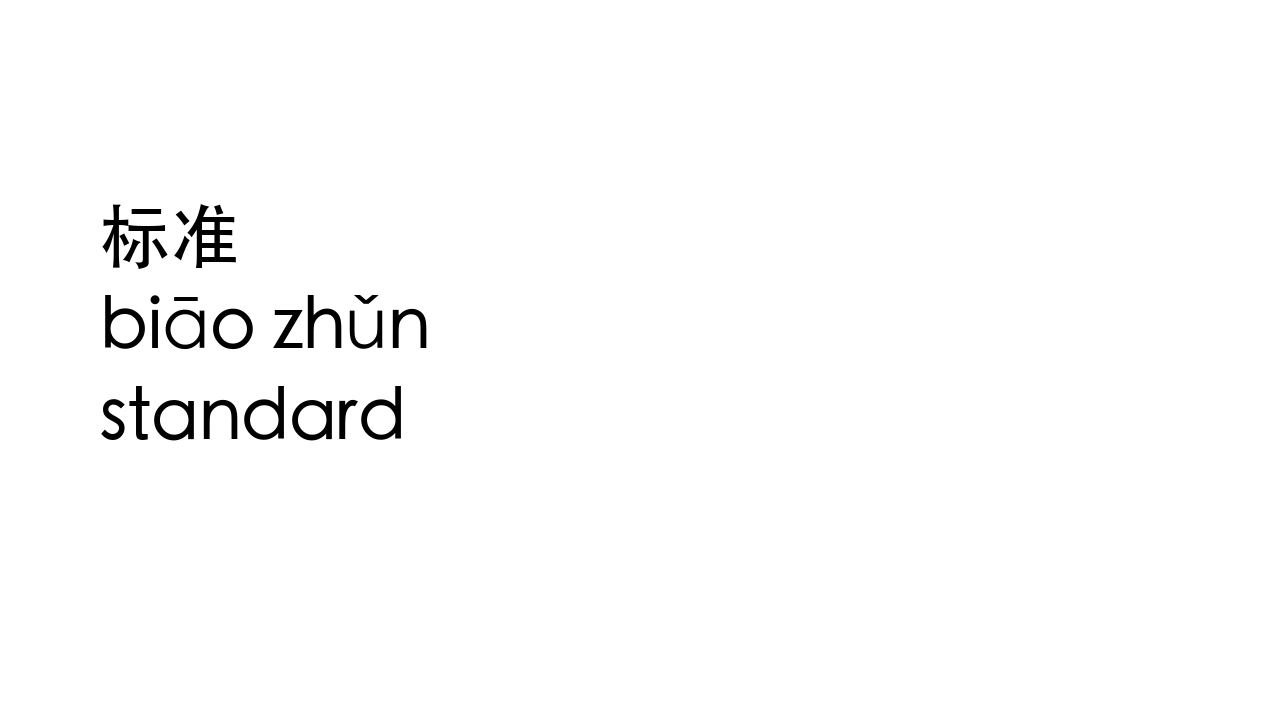

In [11]:
def create_text_clip(text, duration, timestamp_start, image_file_name, size=(1280, 720), bg_color='white', text_color='black', font_path=hanzi_font_path):
    # Use textcip
    # clip_c = TextClip(text=f"{chinese}\n{pinyin}", font='Marker Felt', font_size=70, color=text_color, bg_color=bg_color, size=size, method='label', duration=duration_text_c)
    img = Image.new("RGB", size, color=bg_color)
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype(font_path, 70)
    draw.multiline_text((100, 200), text, font=font, fill=text_color, spacing=30)
    img.save(f"audio_files/img_for_video/{image_file_name}.png")
    clip = ImageClip(f"audio_files/img_for_video/{image_file_name}.png", duration=duration).with_start(timestamp_start)
    return clip
    
# Create all clips
clips = []
for idx, row in df_video.iterrows():
    clips.append(create_text_clip(f"{row['chinese']}\n{row['pinyin']}", row['duration_text_c'], row['timestamp_c'], f"{row['chinese']}_chinese"))
    clips.append(create_text_clip(f"{row['chinese']}\n{row['pinyin']}\n{row['english']}", row['duration_text_e'], row['timestamp_e'], f"{row['chinese']}_english"))
    clips.append(create_text_clip(f"{row['sentence']}\n{row['sentence_pinyin']}", row['duration_sent_c'], row['timestamp_sent_c'], f"{row['chinese']}_sentence"))
    clips.append(create_text_clip(f"{row['sentence']}\n{row['sentence_pinyin']}\n{row['sentence_english']}", row['duration_sent_e'], row['timestamp_sent_e'], f"{row['chinese']}_sentence_e"))
    print(f'{idx}: {row["chinese"]}')

clips[1].display_in_notebook() 

# 4. Create video with audio

In [14]:
# Load audio
audio = AudioFileClip(f"audio_files/products/{recording_id}_{recording_name}.mp3")
audio.duration

# Compare durations of audio and video
all_clips_duration = sum(clip.duration for clip in clips)
print(f"Audio: {audio.duration:.3f} seconds")
print(f"Video: {all_clips_duration:.3f} seconds")

Audio: 6001.340 seconds
Video: 6001.275 seconds


In [ ]:
# Combine clips
video = CompositeVideoClip(clips, size=(1280,720))
video.audio = audio
video.duration = audio.duration

# Export video
video.write_videofile(f"audio_files/products/{recording_id}_{recording_name}.mp4", fps=24)

MoviePy - Building video audio_files/products/001_0814_word_p2_k2_sent.mp4.
MoviePy - Writing audio in 001_0814_word_p2_k2_sentTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
MoviePy - Writing video audio_files/products/001_0814_word_p2_k2_sent.mp4



MoviePy - Done !
MoviePy - video ready audio_files/products/001_0814_word_p2_k2_sent.mp4
